In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
from statsmodels.stats import weightstats as stests

from matplotlib import rcParams

Global seed set to 0


In [2]:
plt.rcParams['axes.grid'] = False

In [2]:
scvi.settings.seed = 1234567

Global seed set to 1234567


We can directly load the 5r_6h adata object from GEO to visualize the expression pattern of heat shock response genes.

In [ ]:
adata_5r = scvi.data.read_h5ad("onlymRNA_scVI_5r_timecourse_merged_seed1234567.h5ad")

This is how we get adata_5r by merging different adata.

In [ ]:
adata1 = scvi.data.read_h5ad("onlymRNA_scVI_JE2_timecourse_g20250516_seed12.h5ad")
adata1

AnnData object with n_obs × n_vars = 189710 × 2407
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: '_scvi', 'leiden', 'leiden_scVI_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [7]:
adata1.obs['sample'] = adata1.obs['sample'].str.replace(r'^OD=(.*)', r'JE2_\1', regex=True)
adata1.obs['sample'].value_counts()

JE2_0.3    74937
JE2_0.1    74661
JE2_0.9    34008
5r_6h       6104
Name: sample, dtype: int64

In [ ]:
adata2 = scvi.data.read_h5ad("onlymRNA_scVI_JE2_D4_merged_explagstat_seed1234567.h5ad")
adata2

AnnData object with n_obs × n_vars = 230050 × 2297
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI', '_scvi_raw_norm_scaling', 'OD', 'cluster', 'batch'
    var: 'n_cells_by_counts-adata1', 'mean_counts-adata1', 'log1p_mean_counts-adata1', 'pct_dropout_by_counts-adata1', 'total_counts-adata1', 'log1p_total_counts-adata1', 'n_counts-adata1', 'n_cells_by_counts-adata2', 'mean_counts-adata2', 'log1p_mean_counts-adata2', 'pct_dropout_by_counts-adata2', 'total_counts-adata2', 'log1p_total_counts-adata2', 'n_counts-adata2'
    uns: 'OD_colors', '_scvi', 'cluster_colors', 'leiden', 'leiden_scVI_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', 'latent'
    layers: 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [8]:
adata2.obs['sample'].value_counts()

lag     66574
D4_3    37217
exp     36563
D4_2    30860
D4_1    30376
stat    28460
Name: sample, dtype: int64

In [9]:
adata2.obs['OD'].value_counts()

0.1    66574
0.9    37217
0.2    36563
0.6    30860
0.3    30376
9      28460
Name: OD, dtype: int64

In [12]:
adata2.obs['sample'] = '4r_' + adata2.obs['OD'].astype(str)
adata2.obs['sample'].value_counts()

4r_0.1    66574
4r_0.9    37217
4r_0.2    36563
4r_0.6    30860
4r_0.3    30376
4r_9      28460
Name: sample, dtype: int64

In [13]:
# Concatenate the two AnnData objects
adata = adata1.concatenate(adata2, batch_key="batch", batch_categories=["adata1", "adata2"])
adata

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 419760 × 2284
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'sample', 'n_counts', '_scvi_batch', '_scvi_labels', 'leiden_scVI', '_scvi_raw_norm_scaling', 'OD', 'cluster', 'batch'
    var: 'n_cells_by_counts-adata1', 'mean_counts-adata1', 'log1p_mean_counts-adata1', 'pct_dropout_by_counts-adata1', 'total_counts-adata1', 'log1p_total_counts-adata1', 'n_counts-adata1', 'n_cells_by_counts-adata1-adata2', 'mean_counts-adata1-adata2', 'log1p_mean_counts-adata1-adata2', 'pct_dropout_by_counts-adata1-adata2', 'total_counts-adata1-adata2', 'log1p_total_counts-adata1-adata2', 'n_counts-adata1-adata2', 'n_cells_by_counts-adata2-adata2', 'mean_counts-adata2-adata2', 'log1p_mean_counts-adata2-adata2', 'pct_dropout_by_counts-adata2-adata2', 'total_counts-adata2-adata2', 'log1p_total_counts-adat

In [14]:
sc.pp.calculate_qc_metrics(adata)

(                                            n_genes_by_counts  \
 Cell Barcode                                                    
 BS29198A_bc1_10_bc2_10_bc3_31-adata1                       35   
 BS29198A_bc1_10_bc2_10_bc3_38-adata1                       15   
 BS29198A_bc1_10_bc2_10_bc3_78-adata1                       55   
 BS29198A_bc1_10_bc2_10_bc3_84-adata1                       16   
 BS29198A_bc1_10_bc2_10_bc3_91-adata1                       10   
 ...                                                       ...   
 BS27884A_bc1_9_bc2_96_bc3_75-adata2-adata2                 78   
 BS27884A_bc1_9_bc2_9_bc3_22-adata2-adata2                  58   
 BS27884A_bc1_9_bc2_9_bc3_32-adata2-adata2                  90   
 BS27884A_bc1_9_bc2_9_bc3_44-adata2-adata2                 182   
 BS27884A_bc1_9_bc2_9_bc3_47-adata2-adata2                  20   
 
                                             log1p_n_genes_by_counts  \
 Cell Barcode                                                       

In [49]:
adata1.obs['total_counts'].median()

32.0

In [53]:
adata1[adata1.obs['sample']=='JE2_0.1'].obs['total_counts'].median()

23.0

In [51]:
adata1[adata1.obs['sample']=='JE2_0.3'].obs['total_counts'].median()

39.0

In [52]:
adata1[adata1.obs['sample']=='JE2_0.9'].obs['total_counts'].median()

62.0

In [50]:
adata2.obs['total_counts'].median()

54.0

In [54]:
adata2[adata2.obs['OD']=='0.1'].obs['total_counts'].median()

69.0

In [55]:
adata2[adata2.obs['OD']=='0.3'].obs['total_counts'].median()

74.0

In [57]:
adata2[adata2.obs['OD']=='0.6'].obs['total_counts'].median()

48.0

In [56]:
adata2[adata2.obs['OD']=='0.9'].obs['total_counts'].median()

48.0

In [15]:
adata.raw = adata # Freeze current version

scvi.data.setup_anndata(adata)

model = scvi.model.SCVI(adata,
                        n_layers=2,
                        n_latent=5,
                        n_hidden=64,
                        dropout_rate=0.1,
                        gene_likelihood='zinb',
                        dispersion='gene'
                       )
model.train()

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 419760 cells, 2284 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/Users/peien/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 19/19: 100%|██████████| 19/19 [41:28<00:00, 131.00s/it, loss=169, v_num=1]


In [16]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [17]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [18]:
sc.pp.neighbors(adata, use_rep='X_scVI')
sc.tl.umap(adata)

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDepr

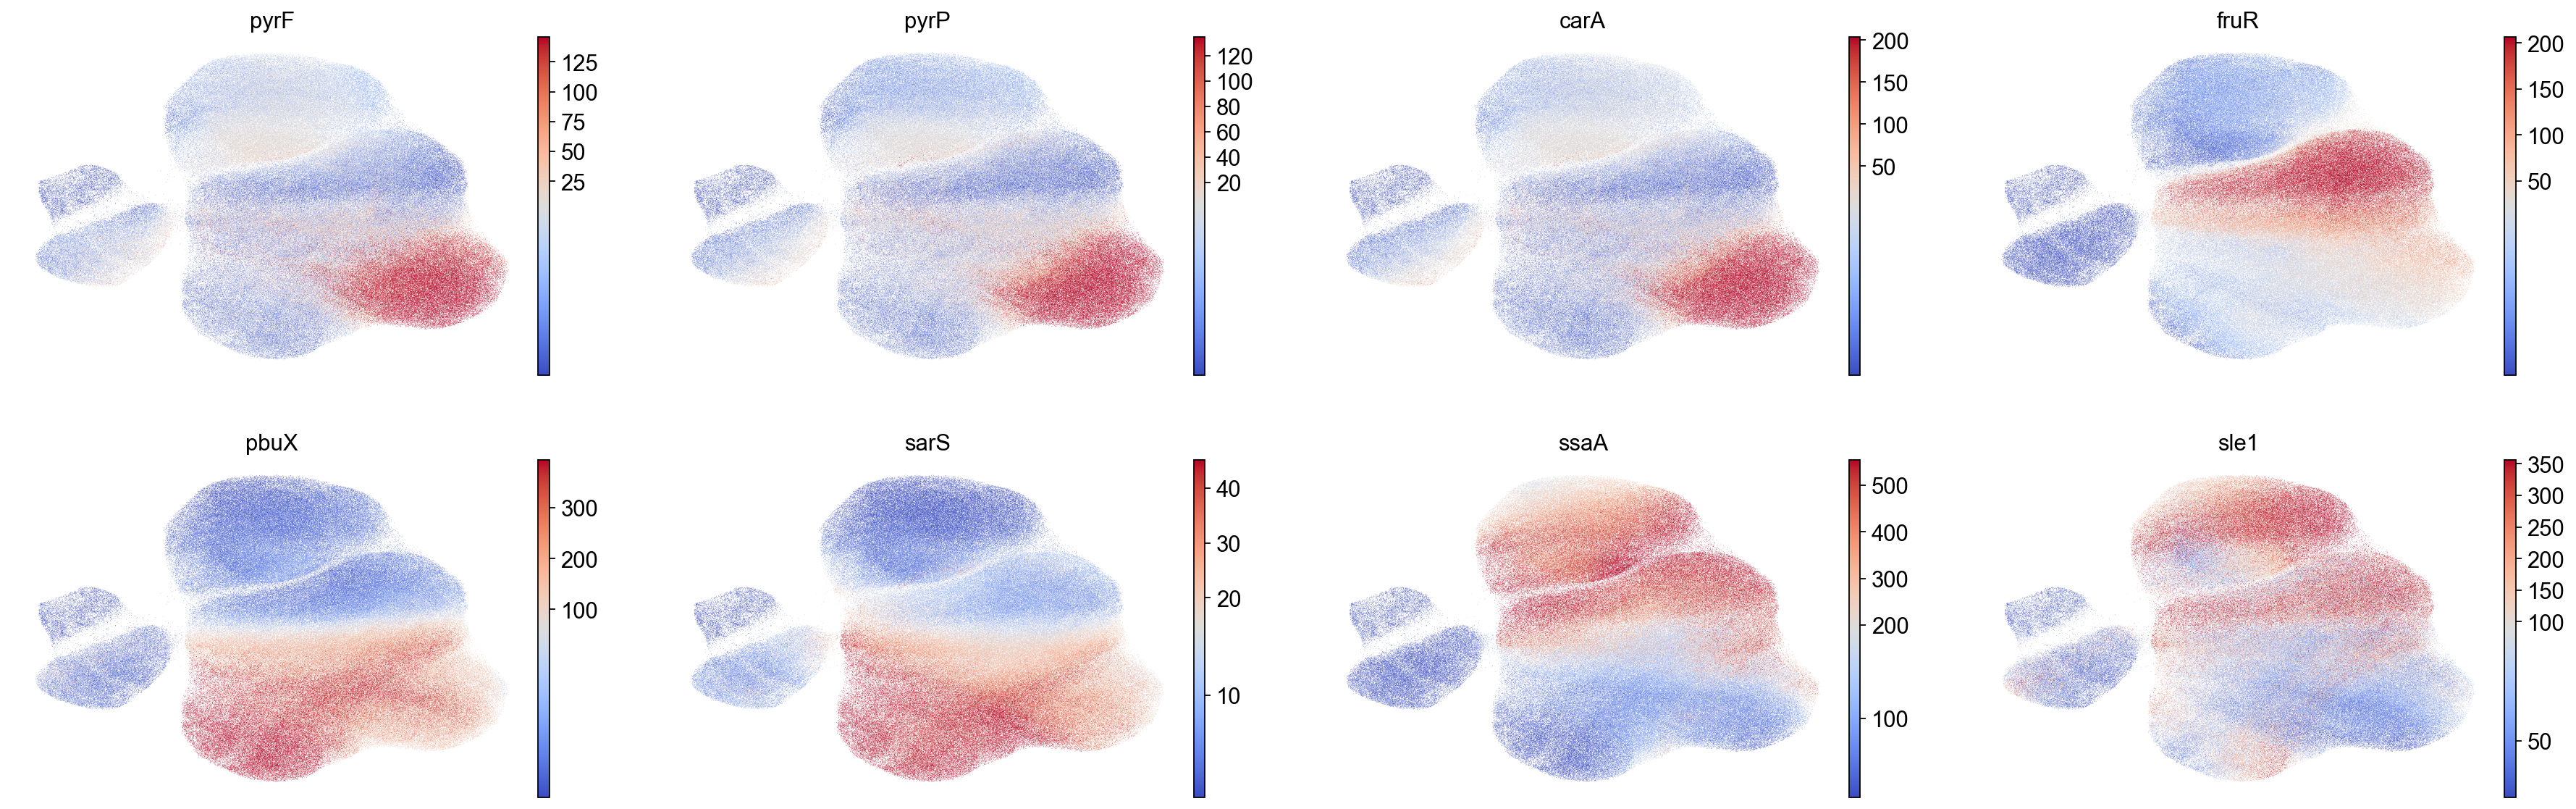

In [19]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.umap(
    adata,
    color=["pyrF","pyrP","carA","fruR","pbuX","sarS","ssaA","sle1"],
    frameon=False,
    layer="scvi_normalized",
    cmap="coolwarm",
    vmax='p90',
    vcenter='p50',
    vmin='p10',
    save="markers_merged.pdf"
)

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


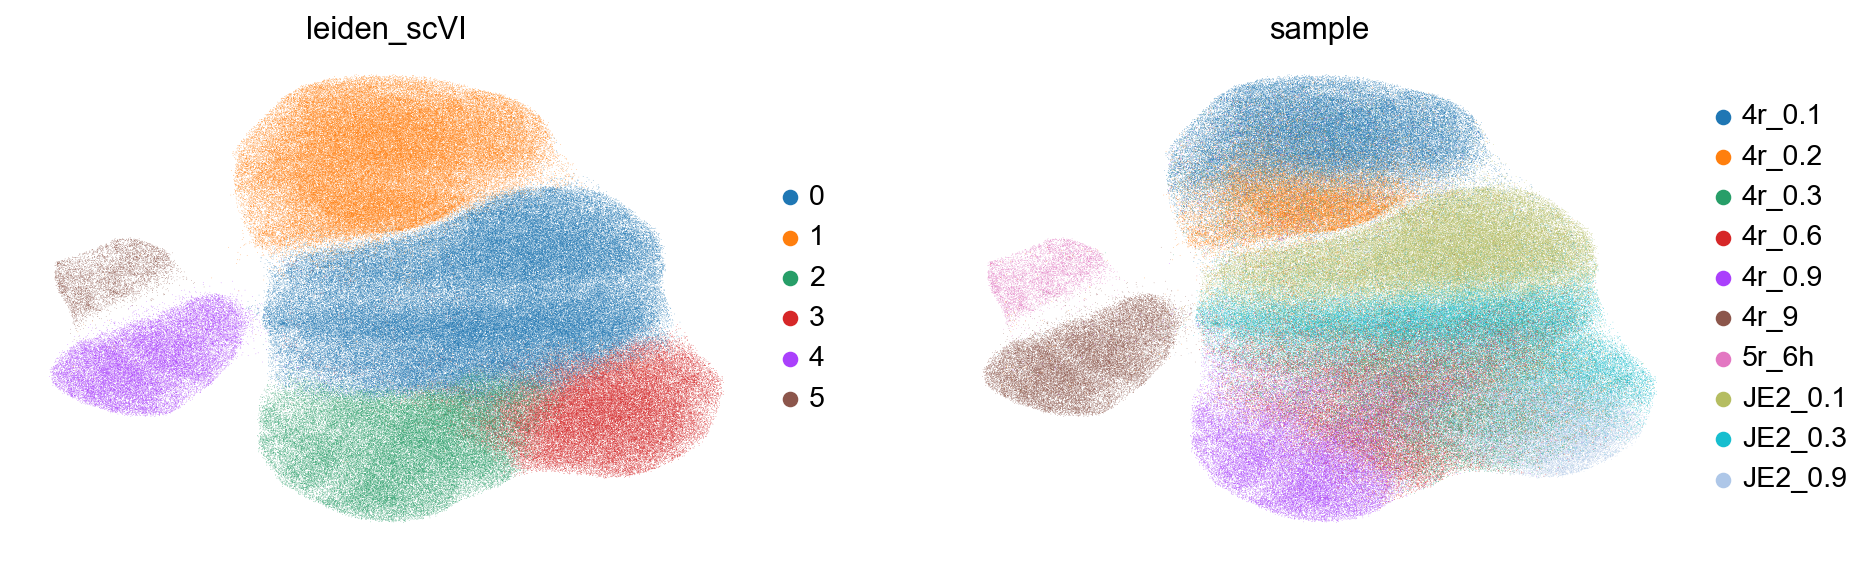

In [20]:
#Clustering on the scVI latent space

sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.1)
sc.set_figure_params(figsize=(6, 4))
sc.pl.umap(
    adata,
    color=["leiden_scVI","sample"],
    frameon=False,
    save="leiden_scVI.pdf"
)

In [ ]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.umap(
    adata,
    color=["sample"],
    frameon=False,
    palette=['#F2DB96', '#E8BE74', "#E29B59", "#B9D0E6", "#8CB6E3", "#6384be"],
    save="0r_seed123.pdf"
)

In [22]:
model.save('onlymRNA_scVI_JE2_timecourse_merged_seed1234567')

In [3]:
adata.obs['sample'].value_counts()

0r_0.3       74937
0r_0.1       74661
4r_0.1       66574
4r_0.9       37217
4r_0.2       36563
0r_0.9       34008
4r_0.6       30860
4r_0.3       30376
5r_GEN_0h    28460
5r_GEN_6h     6104
Name: sample, dtype: int64

In [6]:
adata.obs['sample'] = adata.obs['sample'].str.replace('JE2', '0r')
adata.obs['sample'] = adata.obs['sample'].str.replace('4r_9', '5r_GEN_0h')
adata.obs['sample'] = adata.obs['sample'].str.replace('5r_6h', '5r_GEN_6h')
adata.obs['sample'].value_counts()

0r_0.3       74937
0r_0.1       74661
4r_0.1       66574
4r_0.9       37217
4r_0.2       36563
0r_0.9       34008
4r_0.6       30860
4r_0.3       30376
5r_GEN_0h    28460
5r_GEN_6h     6104
Name: sample, dtype: int64

In [4]:
adata_5r = adata[(adata.obs['sample'].str.contains('5r_GEN')) |  (adata.obs['sample'].str.contains('4r'))]
adata_5r.obs['sample'].value_counts()

4r_0.1       66574
4r_0.9       37217
4r_0.2       36563
4r_0.6       30860
4r_0.3       30376
5r_GEN_0h    28460
5r_GEN_6h     6104
Name: sample, dtype: int64

In [5]:
adata_5r.write_h5ad("onlymRNA_scVI_5r_timecourse_merged_seed1234567.h5ad")

In [7]:
#PSEUDOBULK deseq2
X = adata_5r.raw.X                  # raw counts matrix
genes = adata_5r.raw.var_names      # genes in raw
samples = adata_5r.obs['sample'].astype(str).to_numpy()
uniq = pd.unique(samples)

rows = []
for s in uniq:
    mask = samples == s
    Xs = X[mask]
    rows.append(np.asarray(Xs.sum(axis=0)).ravel())

sum_df = pd.DataFrame(rows, index=uniq, columns=genes) 
sum_df


dnaA    dnaN  SAUSA300_RS00020    recF    gyrB    gyrA    nnrD  \
5r_GEN_6h    19.0    16.0               8.0    62.0   139.0   121.0     1.0   
4r_0.1     1078.0  1096.0             119.0  1288.0  2699.0  2731.0  3963.0   
4r_0.2     1914.0  1889.0             147.0  1097.0  2514.0  2987.0  1751.0   
5r_GEN_0h   434.0   356.0              40.0   490.0  1109.0   935.0    15.0   
4r_0.3     1141.0  1372.0              69.0  1122.0  3295.0  4173.0   208.0   
4r_0.6      879.0   800.0              57.0   858.0  2383.0  2680.0   104.0   
4r_0.9     1668.0  1801.0             121.0  1404.0  3676.0  3610.0   104.0   

            hutH   serS  SAUSA300_RS00055  ...    tmRNA  SAUSA300_RS15260  \
5r_GEN_6h    9.0    1.0               0.0  ...    871.0               1.0   
4r_0.1     207.0  665.0              79.0  ...   9194.0              73.0   
4r_0.2     324.0  869.0             121.0  ...  13596.0             105.0   
5r_GEN_0h   55.0   25.0               3.0  ...   5880.0              14.0   
4r_0.3      48.0  708.0              50.0  ...   5844.0              52.0   
4r_0.6      24.0  511.0              51.0  ...   2116.0              31.0   
4r_0.9      18.0  968.0             145.0  ...   5521.0              18.0   

           SAUSA300_RS15340  SAUSA300_RS15370   epiG  SAUSA300_RS15490  \
5r_GEN_6h             237.0            1965.0  172.0               0.0   
4r_0.1               7544.0            2397.0  277.0              41.0   
4r_0.2               9573.0            2634.0  251.0             149.0   
5r_GEN_0h            3001.0           11225.0  382.0               9.0   
4r_0.3               5274.0             378.0   46.0              34.0   
4r_0.6               3376.0             140.0   25.0              23.0   
4r_0.9               4877.0            1493.0   55.0              25.0   

           SAUSA300_RS15635  SAUSA300_RS15735  SAUSA300_RS15740  \
5r_GEN_6h               0.0               0.0               0.0   
4r_0.1                238.0              19.0              14.0   
4r_0.2                377.0              19.0              24.0   
5r_GEN_0h               9.0            1070.0             615.0   
4r_0.3                 29.0               2.0               7.0   
4r_0.6                 10.0               2.0               2.0   
4r_0.9                 11.0               3.0               0.0   

           SAUSA300_RS15795  
5r_GEN_6h               2.0  
4r_0.1                 45.0  
4r_0.2                113.0  
5r_GEN_0h              19.0  
4r_0.3                 25.0  
4r_0.6                 17.0  
4r_0.9                 17.0  

[7 rows x 2284 columns]

In [8]:
sum_df.to_csv("sample_5radata_sum_counts_raw.csv")

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed 

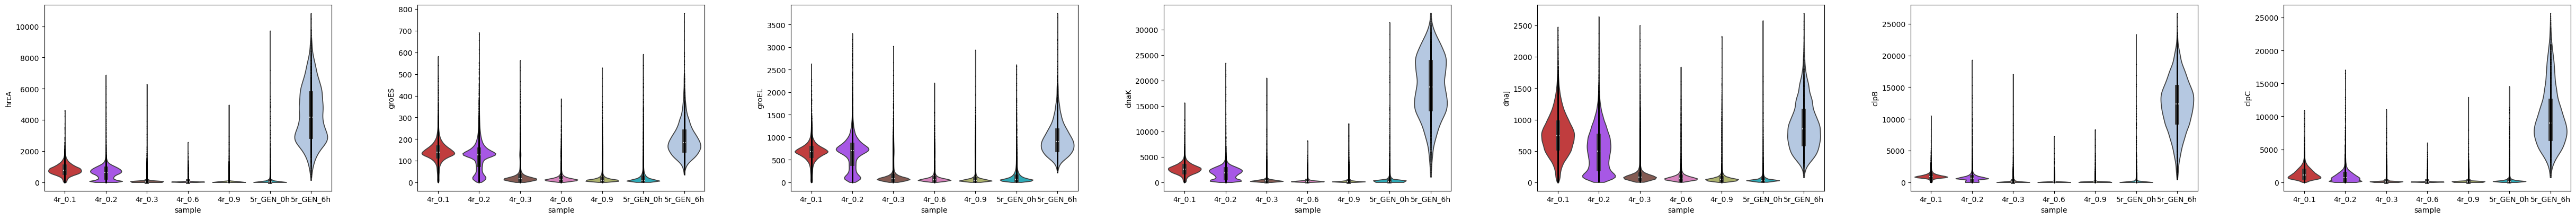

In [18]:
sc.pl.violin(adata_5r, 
             keys=['hrcA','groES','groEL','dnaK','dnaJ','clpB','clpC'] ,
             groupby='sample',use_raw=False,layer="scvi_normalized", 
             jitter=False, inner="box",save="hrcA_5r.pdf")

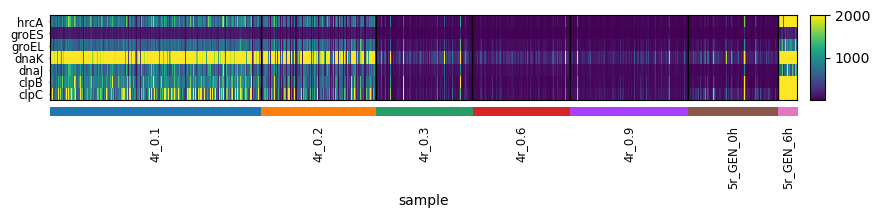

In [15]:
sc.pl.heatmap(adata_5r, 
             var_names=['hrcA','groES','groEL','dnaK','dnaJ','clpB','clpC'] ,
             groupby='sample',use_raw=False,layer="scvi_normalized", 
             swap_axes=True,
             vmax=2000,
             save="heatshock_5r.pdf")

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


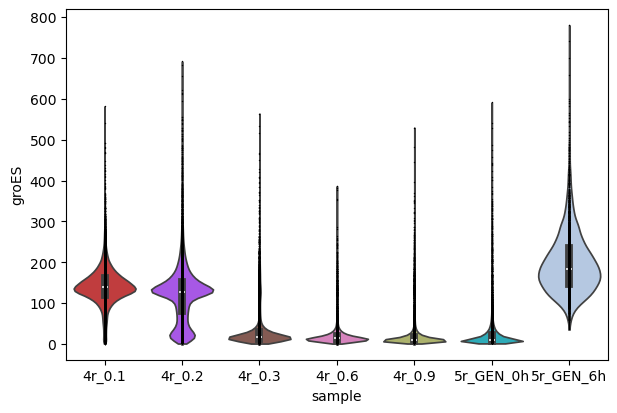

In [5]:
sc.pl.violin(adata_5r, 
             keys=['groES'] ,
             groupby='sample',use_raw=False,layer="scvi_normalized", 
             jitter=False, inner="box",save="groES_5r.pdf")

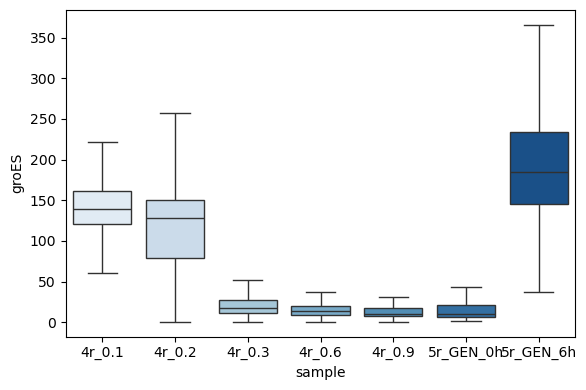

In [23]:
# Now, plot it
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_plot, x='sample', y='groES', hue='sample',
             palette='Blues',
             showfliers=False,
             width=0.8,
             #dodge=True
             )
plt.tight_layout()
plt.savefig("groES_boxplot.pdf")
plt.show()

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_3085/538594099.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


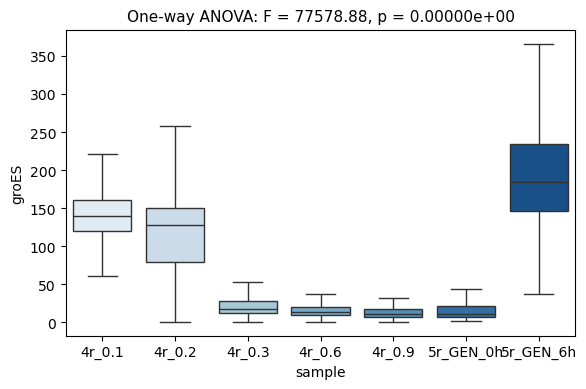

In [27]:
from scipy import stats

# 1) Compute one-way ANOVA across groups in `sample`
groups = [g['groES'].dropna().values for _, g in df_plot.groupby('sample')]
F, p = stats.f_oneway(*groups)

# 2) Plot
plt.figure(figsize=(6, 4))
ax = sns.boxplot(
    data=df_plot,
    x='sample',
    y='groES',
    # hue='sample',            # not needed; it duplicates the legend/colors
    palette='Blues',
    showfliers=False,
    width=0.8
)

# 3) Add the ANOVA result to the plot (top-center)
ax.text(
    0.5, 1.02,
    f"One-way ANOVA: F = {F:.2f}, p = {p:.5e}",
    transform=ax.transAxes,
    ha='center', va='bottom', fontsize=11
)

plt.tight_layout()
plt.savefig("groES_boxplot_with_anova.pdf")
plt.show()


In [8]:
df_plot = pd.DataFrame({ #['hrcA','groES','groEL','dnaK','dnaJ','clpB','clpC'] 
    'sample': adata_5r.obs['sample'],
    'hrcA': adata_5r[:, 'hrcA'].layers['scvi_normalized'].flatten(),  
    'groES': adata_5r[:, 'groES'].layers['scvi_normalized'].flatten(), 
    'groEL': adata_5r[:, 'groEL'].layers['scvi_normalized'].flatten(), 
    'dnaK': adata_5r[:, 'dnaK'].layers['scvi_normalized'].flatten(), 
    'dnaJ': adata_5r[:, 'dnaJ'].layers['scvi_normalized'].flatten(), 
    'clpB': adata_5r[:, 'clpB'].layers['scvi_normalized'].flatten(), 
    'clpC': adata_5r[:, 'clpC'].layers['scvi_normalized'].flatten(), 
})

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_93901/3434717395.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


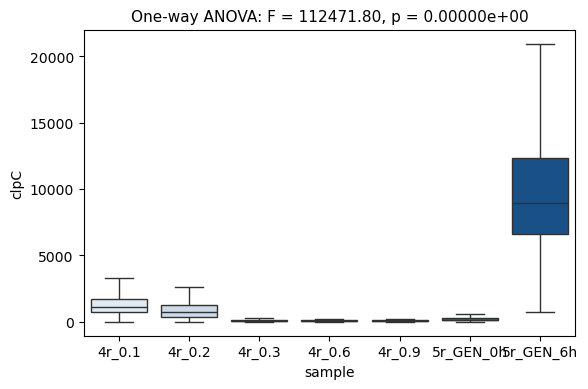

In [22]:
from scipy import stats

# 1) Compute one-way ANOVA across groups in `sample`
groups = [g['clpC'].dropna().values for _, g in df_plot.groupby('sample')]
F, p = stats.f_oneway(*groups)

# 2) Plot
plt.figure(figsize=(6, 4))
ax = sns.boxplot(
    data=df_plot,
    x='sample',
    y='clpC',
    order=['4r_0.1', '4r_0.2', '4r_0.3', '4r_0.6', '4r_0.9',  '5r_GEN_0h', '5r_GEN_6h'],
    palette='Blues',
    showfliers=False,
    width=0.8
)

# 3) Add the ANOVA result to the plot (top-center)
ax.text(
    0.5, 1.02,
    f"One-way ANOVA: F = {F:.2f}, p = {p:.5e}",
    transform=ax.transAxes,
    ha='center', va='bottom', fontsize=11
)

plt.tight_layout()
plt.savefig("clpC_boxplot_with_anova.pdf")
plt.show()

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


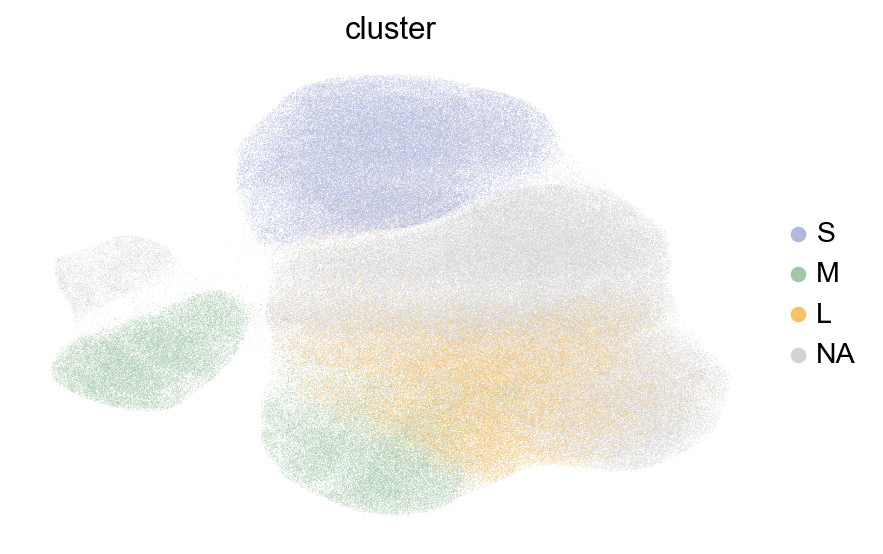

In [31]:
sc.set_figure_params(figsize=(6, 4))
sc.pl.umap(
    adata,
    color=["cluster"],
    palette=['#B1B8DD', '#A2C7A7','#F7C167'],  
    frameon=False,
    save="cluster_old.pdf"
)

In [18]:
de_df = model.differential_expression(
    groupby="sample"
)
de_df

DE...: 100%|██████████| 10/10 [04:59<00:00, 29.99s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
SAUSA300_RS04510    0.9846        0.0154      4.157867  0.000791  0.000182   
SAUSA300_RS04505    0.9832        0.0168      4.069433  0.000164  0.000040   
mcsA                0.9830        0.0170      4.057395  0.002048  0.000547   
vraF                0.9826        0.0174      4.033731  0.000637  0.000120   
cstB                0.9814        0.0186      3.965818  0.000903  0.000135   
...                    ...           ...           ...       ...       ...   
truA                0.5624        0.4376      0.250908  0.000337  0.000277   
SAUSA300_RS03920    0.5616        0.4384      0.247658  0.000074  0.000081   
gcp                 0.5592        0.4408      0.237916  0.000203  0.000189   
hemY                0.5208        0.4792      0.083248  0.000529  0.000477   
recQ1               0.5164        0.4836      0.065624  0.000449  0.000427   

                  pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
SAUSA300_RS04510           0.0   0.25  2.333190    2.400104  0.977270  ...   
SAUSA300_RS04505           0.0   0.25  2.227865    2.302578  0.959495  ...   
mcsA                       0.0   0.25  4.567027    5.030072  2.669699  ...   
vraF                       0.0   0.25  2.757462    2.898423  1.198554  ...   
cstB                       0.0   0.25  3.878648    4.284940  1.759604  ...   
...                        ...    ...       ...         ...       ...  ...   
truA                       0.0   0.25  0.355293    0.241999  0.574708  ...   
SAUSA300_RS03920           0.0   0.25 -0.063916   -0.100254  0.594258  ...   
gcp                        0.0   0.25  0.166385    0.114820  0.559502  ...   
hemY                       0.0   0.25  0.219921    0.105253  0.608259  ...   
recQ1                      0.0   0.25  0.108530    0.066161  0.540426  ...   

                  raw_mean1  raw_mean2  non_zeros_proportion1  \
SAUSA300_RS04510   0.067609   0.009641               0.063538   
SAUSA300_RS04505   0.015156   0.001982               0.014961   
mcsA               0.154760   0.020694               0.135488   
vraF               0.053940   0.005776               0.050590   
cstB               0.066603   0.009678               0.059438   
...                     ...        ...                    ...   
truA               0.021789   0.016692               0.021083   
SAUSA300_RS03920   0.004587   0.004171               0.004558   
gcp                0.012497   0.010437               0.012321   
hemY               0.036139   0.027077               0.034227   
recQ1              0.030610   0.022284               0.029258   

                  non_zeros_proportion2  raw_normalized_mean1  \
SAUSA300_RS04510               0.009366              8.464115   
SAUSA300_RS04505               0.001962              1.965722   
mcsA                           0.018129             19.621493   
vraF                           0.005589              6.948200   
cstB                           0.008245              8.636413   
...                                 ...                   ...   
truA                           0.016145                   NaN   
SAUSA300_RS03920               0.004122                   NaN   
gcp                            0.010183                   NaN   
hemY                           0.025594                   NaN   
recQ1                          0.021371                   NaN   

                  raw_normalized_mean2  is_de_fdr_0.05       comparison  \
SAUSA300_RS04510                   NaN            True   4r_0.1 vs Rest   
SAUSA300_RS04505                   NaN            True   4r_0.1 vs Rest   
mcsA                               NaN            True   4r_0.1 vs Rest   
vraF                               NaN            True   4r_0.1 vs Rest   
cstB                               NaN            True   4r_0.1 vs Rest   
...                                ...             ...              ...   
truA                               NaN           False  J

In [23]:
markers = {}
cats = adata.obs['sample'].cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2.5]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:8]
    
markers

{'4r_0.1': ['mcsA',
  'SAUSA300_RS12440',
  'clpC',
  'dltA',
  'vraG',
  'mcsB',
  'clpB',
  'SAUSA300_RS10090'],
 '4r_0.2': ['fnbB',
  'fnbA',
  'mcsB',
  'mcsA',
  'clpC',
  'SAUSA300_RS13710',
  'grpE',
  'clpB'],
 '4r_0.3': ['spa', 'carB', 'glcA', 'pbuX', 'glpD'],
 '4r_0.6': ['spa', 'glcA', 'pbuX'],
 '4r_0.9': ['spa', 'guaB', 'guaA', 'pbuX', 'dtpT', 'hchA', 'fdhA', 'asp23'],
 '4r_9': ['mntA',
  'gehB',
  'mntC',
  'hld',
  'SAUSA300_RS15370',
  'mntB',
  'asp23',
  'amaP'],
 '5r_6h': ['clpB', 'clpC', 'mcsB', 'dnaK', 'mcsA', 'ctsR', 'clfA', 'grpE'],
 'JE2_0.1': ['ldh1', 'fruA', 'agrC', 'ausA'],
 'JE2_0.3': ['carB', 'glcA', 'agrC', 'ldh1'],
 'JE2_0.9': ['carB', 'pyrB', 'carA', 'pyrF', 'pyrE', 'pyrC', 'pyrP', 'spa']}

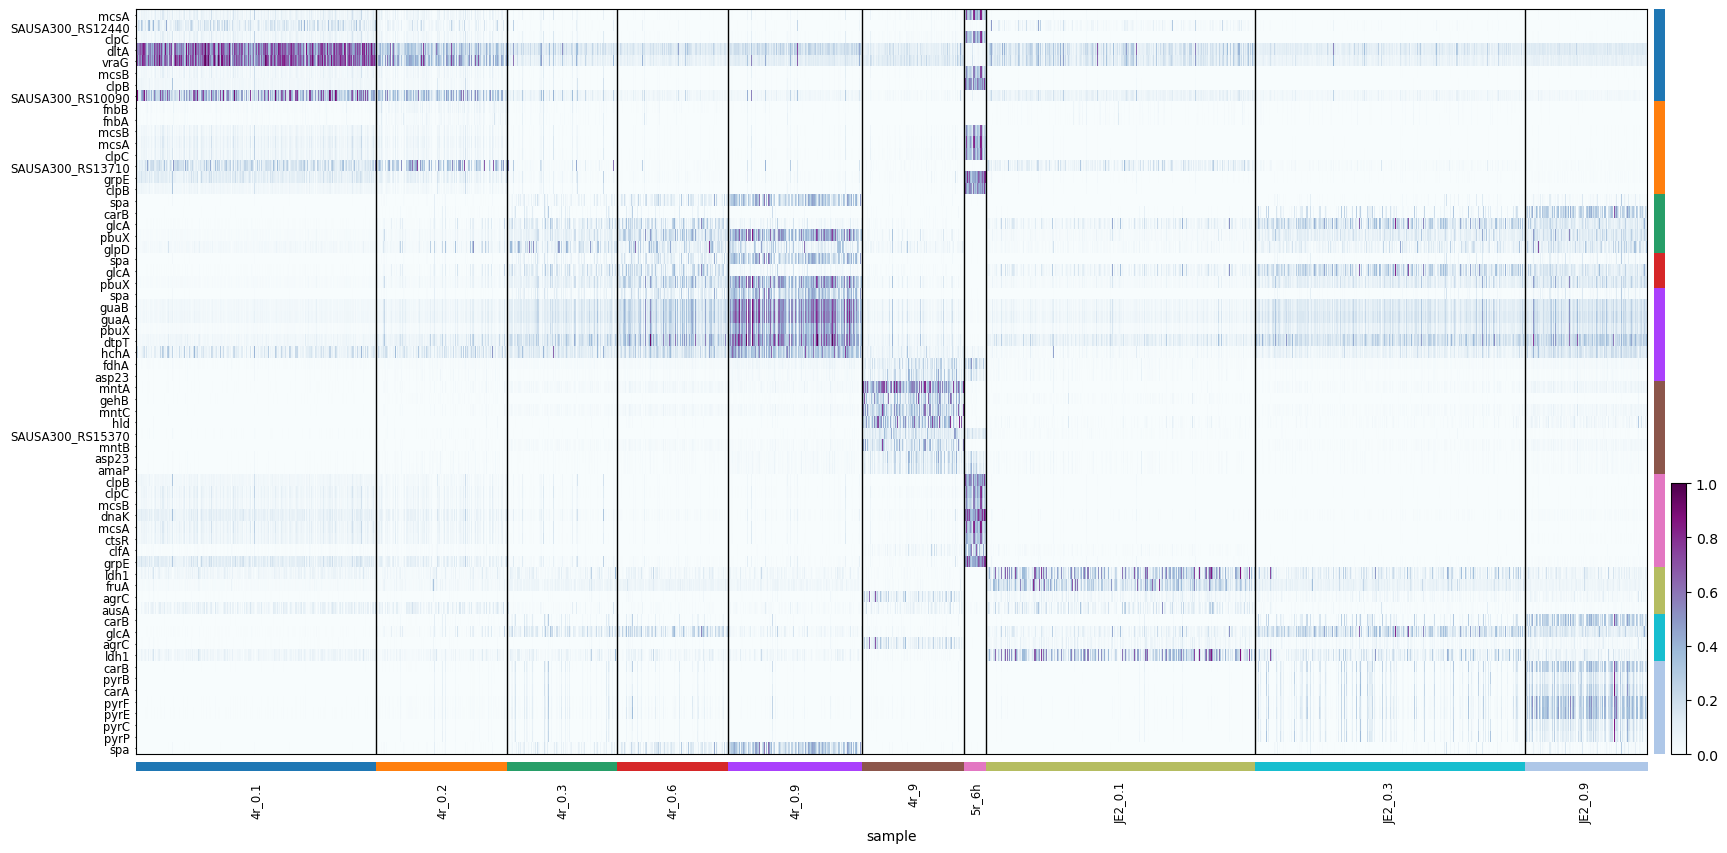

In [24]:
# Plot the heatmap with the downsampled data
sc.pl.heatmap(
    adata,
    markers,
    groupby='sample',
    layer="scvi_normalized",
    standard_scale="var",
    show_gene_labels=True,
    dendrogram=False,
    figsize=(20, 10),
    swap_axes=True, 
    cmap="BuPu",
    save="sample_gene_markers_seed1234567.pdf"
)